In [32]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
path = '/Users/arnavbhatnagar/Downloads/Uber Dataset/dataset.csv'

In [3]:
df = pd.read_csv(path)

In [26]:
# Perform the same initial cleaning as in the EDA and ML notebooks
df['booking_datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df.dropna(subset=['booking_datetime'], inplace=True)

# Set the booking_datetime as the index
df.set_index('booking_datetime', inplace=True)

# For our time series analysis, let's focus on the number of 'Completed' rides.
# We'll resample the data to get the daily count of completed rides.
daily_completed_rides = df[df['Booking Status'] == 'Completed'].resample('D').size().reset_index(name='ride_count')
daily_completed_rides.set_index('booking_datetime', inplace=True)

print("--- Data prepared for Time Series Analysis ---")
print(daily_completed_rides.head())

--- Data prepared for Time Series Analysis ---
                  ride_count
booking_datetime            
2024-01-01               251
2024-01-02               240
2024-01-03               245
2024-01-04               254
2024-01-05               257



--- Visualizing the daily completed rides ---


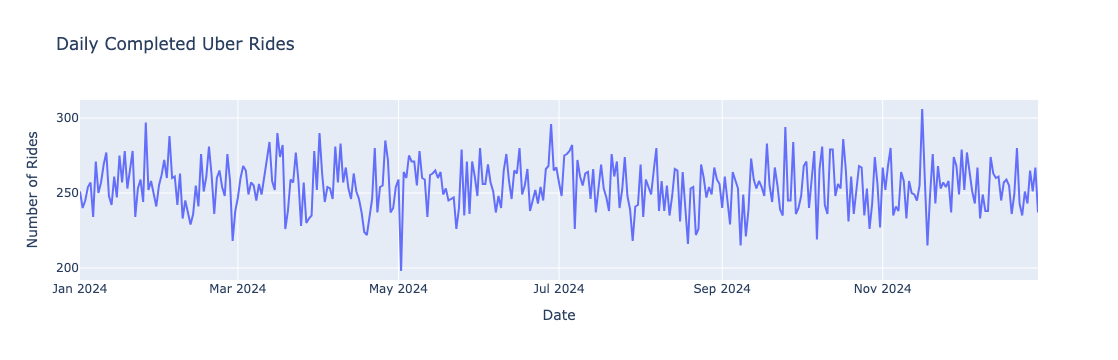

In [30]:
# --- 2. Visualize the Time Series ---
print("\n--- Visualizing the daily completed rides ---")
fig = px.line(daily_completed_rides, x=daily_completed_rides.index, y='ride_count',
              title='Daily Completed Uber Rides', labels={'booking_datetime': 'Date', 'ride_count': 'Number of Rides'})
fig.show()


--- Decomposing the time series ---


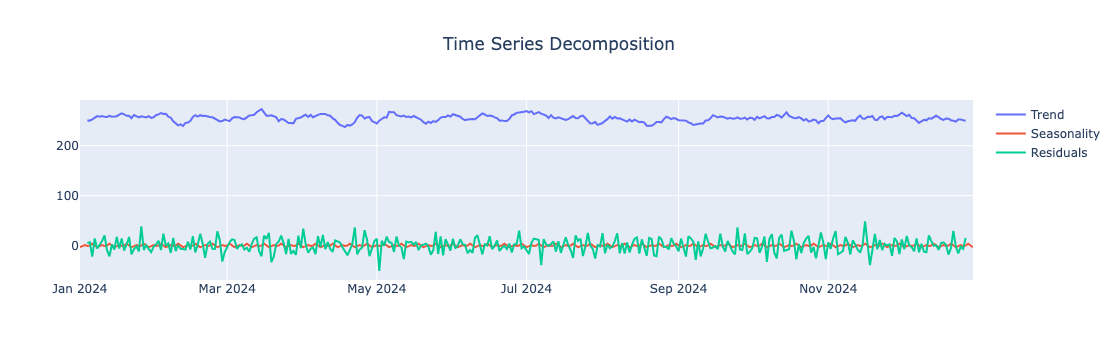

In [33]:
# --- 3. Time Series Decomposition ---
# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(daily_completed_rides['ride_count'], model='additive', period=7) # Assuming weekly seasonality (period=7)

# Plot the decomposition
print("\n--- Decomposing the time series ---")
fig = go.Figure()
fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', name='Trend'))
fig.add_trace(go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, mode='lines', name='Seasonality'))
fig.add_trace(go.Scatter(x=decomposition.resid.index, y=decomposition.resid, mode='lines', name='Residuals'))
fig.update_layout(title_text="Time Series Decomposition", title_x=0.5)
fig.show()

In [34]:
# --- 4. Check for Stationarity ---
# We use the Augmented Dickey-Fuller test to check for stationarity
print("\n--- Checking for stationarity using Augmented Dickey-Fuller test ---")
adf_test = adfuller(daily_completed_rides['ride_count'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
# A p-value less than 0.05 indicates that the series is stationary.



--- Checking for stationarity using Augmented Dickey-Fuller test ---
ADF Statistic: -18.341011749989388
p-value: 2.2460658508048045e-30


In [35]:
# --- 5. Building the SARIMA Model ---
# The data shows clear weekly seasonality, so a SARIMA model is appropriate.
# SARIMA(p,d,q)(P,D,Q,m)
# We will use the decomposed series and ACF/PACF plots to guide our parameter selection.
# Let's start with a common seasonal order for weekly data.
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 7 # Seasonal components

print("\n--- Building and fitting the SARIMA model ---")
sarima_model = SARIMAX(daily_completed_rides['ride_count'],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_results = sarima_model.fit()
print(sarima_results.summary())


--- Building and fitting the SARIMA model ---


/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                        ride_count   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1479.877
Date:                           Sun, 21 Sep 2025   AIC                           2969.753
Time:                                   22:23:17   BIC                           2989.014
Sample:                               01-01-2024   HQIC                          2977.422
                                    - 12-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0310      0.062      0.503      0.615      -0.090       0.152
ma.L1         -1.0000     19.262     -0.052

In [36]:
# --- 6. Forecasting with the SARIMA Model ---
# Let's forecast the next 30 days
print("\n--- Forecasting the next 30 days ---")
forecast_steps = 30
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=daily_completed_rides.index[-1], periods=forecast_steps + 1, freq='D')[1:]
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


--- Forecasting the next 30 days ---


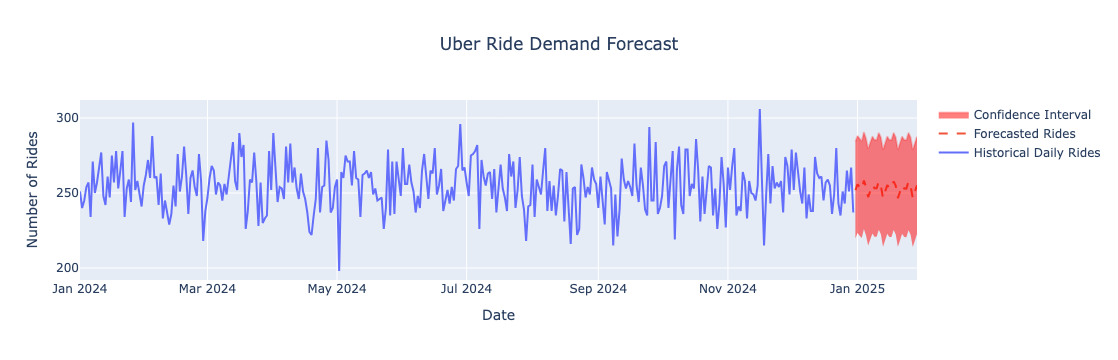

In [37]:
# Plot the forecast
fig = go.Figure()
# Historical data
fig.add_trace(go.Scatter(x=daily_completed_rides.index, y=daily_completed_rides['ride_count'],
                         mode='lines', name='Historical Daily Rides'))
# Forecast
fig.add_trace(go.Scatter(x=forecast_index, y=forecast_values,
                         mode='lines', name='Forecasted Rides', line=dict(dash='dash')))
# Confidence Interval
fig.add_trace(go.Scatter(x=forecast_index, y=confidence_intervals.iloc[:, 0],
                         fill=None, mode='lines', line_color='rgba(0,0,0,0)', name='Lower CI', showlegend=False))
fig.add_trace(go.Scatter(x=forecast_index, y=confidence_intervals.iloc[:, 1],
                         fill='tonexty', mode='lines', line_color='rgba(255, 0, 0, 0.2)', name='Confidence Interval'))

fig.update_layout(title_text="Uber Ride Demand Forecast", title_x=0.5,
                  xaxis_title="Date", yaxis_title="Number of Rides")
fig.show()
